In [102]:
import pandas as pd

auto = pd.read_csv("../../data/Auto.csv", na_values='?').dropna().set_index("name")
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,1
ford torino,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86.0,2790,15.6,82,1
vw pickup,44.0,4,97.0,52.0,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84.0,2295,11.6,82,1


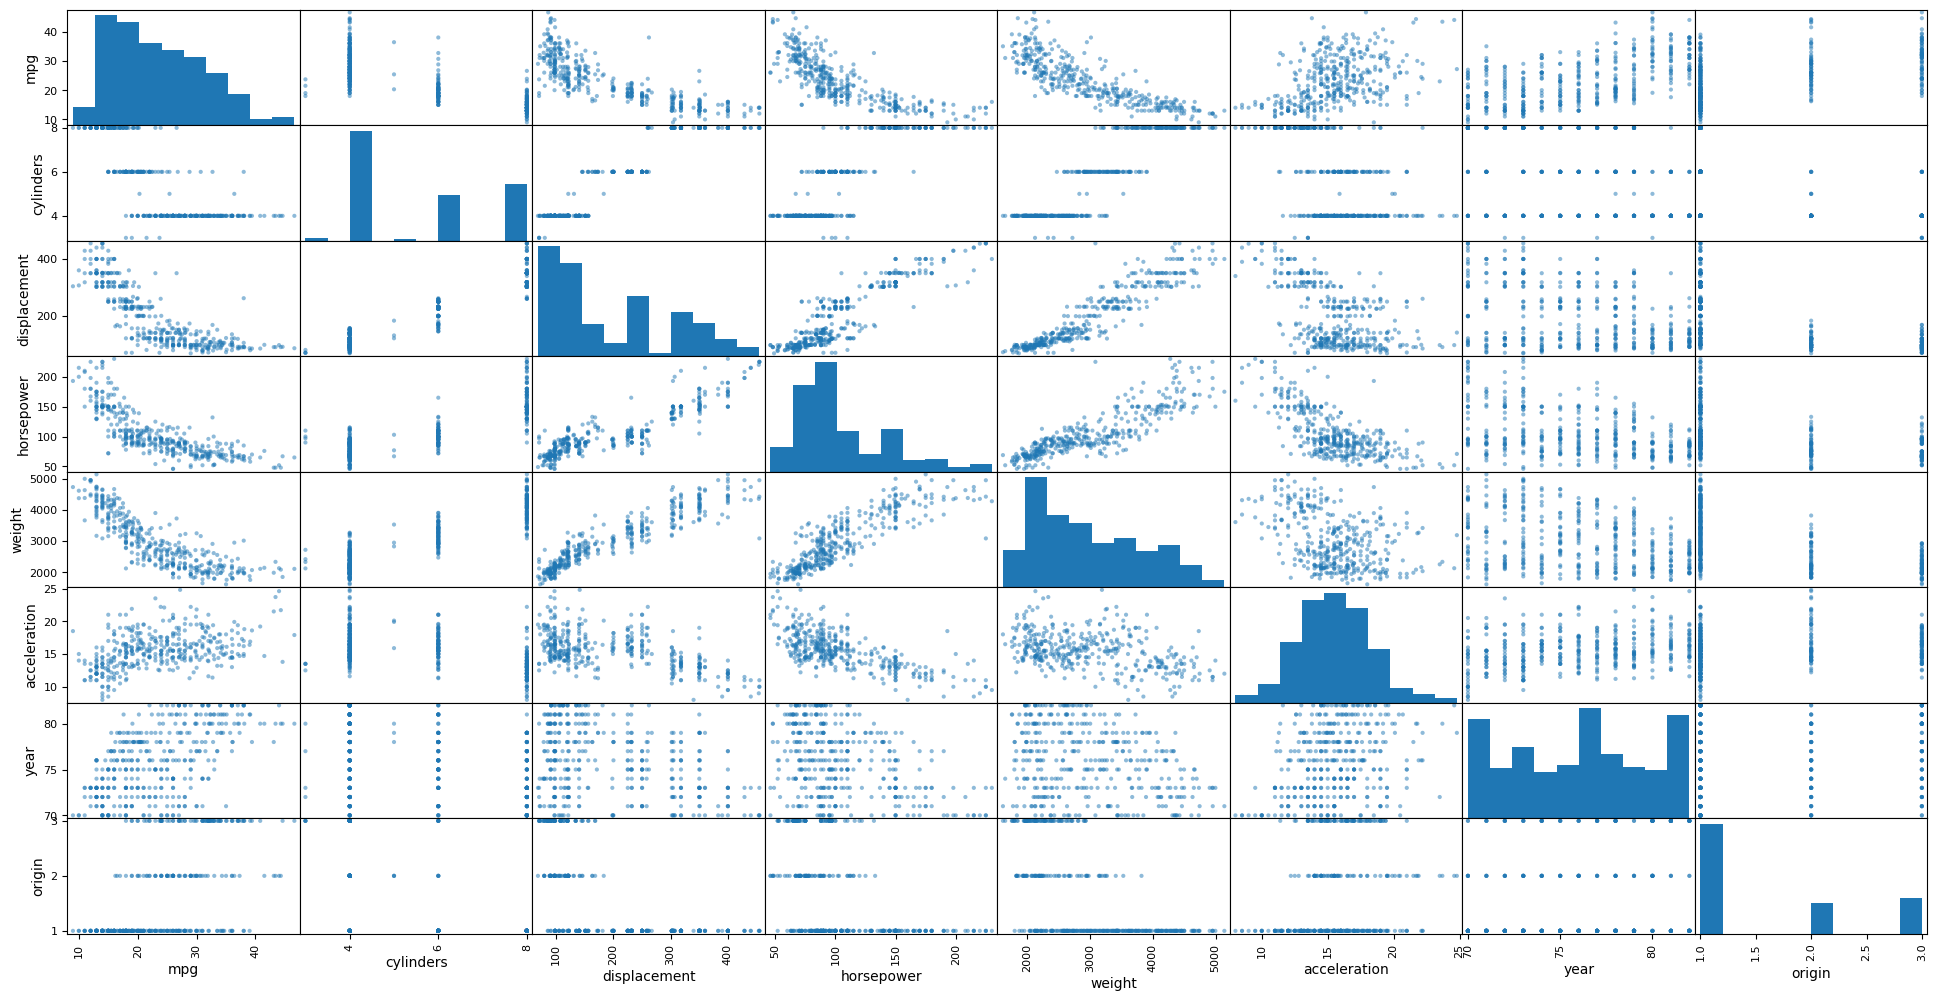

In [103]:
pd.plotting.scatter_matrix(auto, figsize=(24,12));

In [104]:
auto.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


For this dataset, I selected mpg as the target variable because it is both highly relevant and easy to interpret. From the correlation matrix, it is evident that mpg has strong relationships with weight, horsepower, displacement, and cylinders. However, these predictors are also highly correlated with one another, which indicates the presence of multicollinearity. For instance, the correlation between weight and displacement is extremely high at 0.93, showing that they provide very similar information.

To avoid redundancy and instability in the model, it is important to reduce this overlap. Among these correlated features, I chose to retain weight as a predictor, since it has the strongest correlation with mpg and serves as a direct, intuitive measure of a car’s efficiency.

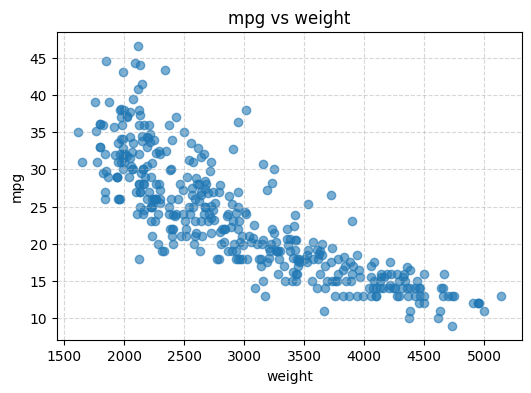

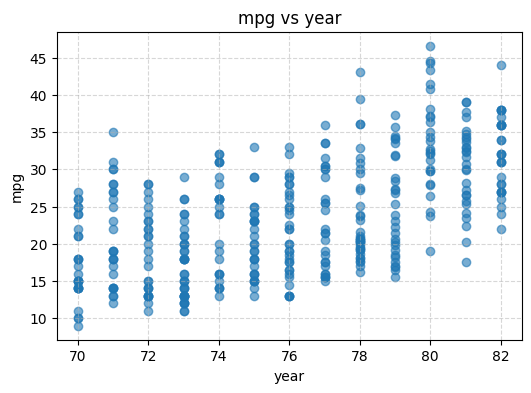

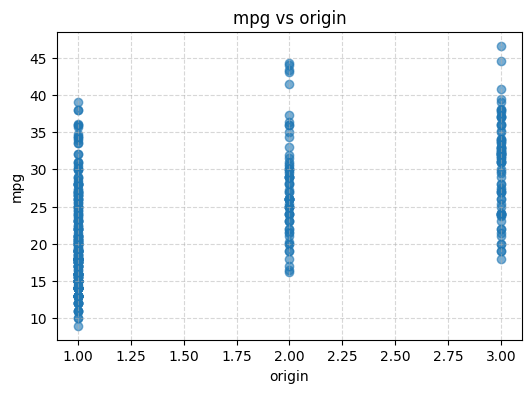

In [105]:
import matplotlib.pyplot as plt
target = "mpg"
features = ["weight", "year", "origin"]

for feature in features:
    plt.figure(figsize=(6, 4))
    plt.scatter(auto[feature], auto[target], alpha=0.6)
    plt.title(f"{target} vs {feature}")
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

In [106]:
from ISLP.models import ModelSpec as MS, poly, sklearn_sm
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import numpy as np
from sklearn.model_selection import cross_validate

models = [MS([poly("weight", degree=d)]) for d in range(1, 10)]
X, Y = auto[["weight"]], auto["mpg"]

optimal_degree = None
optimal_err = np.inf

for degree, model in enumerate(models, start=1):  # start=1 so degree matches polynomial
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_degree = degree

optimal_degree, optimal_err

(2, np.float64(20.05793445474264))

In [107]:
Xs = [model.fit_transform(auto) for model in models]
anova_lm(*[sm.OLS(Y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,7321.233706,0.0,NaN,NaN,NaN
1,389.0,6784.898509,1.0,536.335198,30.524468,6.046248e-08
2,388.0,6784.849925,1.0,0.048584,0.002765,9.580907e-01
3,387.0,6776.965652,1.0,7.884272,0.448718,5.033439e-01
4,386.0,6762.295922,1.0,14.669730,0.834899,3.614301e-01
5,385.0,6751.163846,1.0,11.132076,0.633560,4.265429e-01
6,384.0,6722.006812,1.0,29.157034,1.659416,1.984579e-01
7,383.0,6721.736679,1.0,0.270133,0.015374,9.013864e-01
8,382.0,6711.993931,1.0,9.742748,0.554489,4.569469e-01


In [108]:
optimal_degree_model = MS([poly("weight", degree=2)]).fit_transform(auto)
results = sm.OLS(Y, optimal_degree_model).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     488.3
Date:                Mon, 25 Aug 2025   Prob (F-statistic):          8.39e-107
Time:                        11:00:33   Log-Likelihood:                -1115.1
No. Observations:                 392   AIC:                             2236.
Df Residuals:                     389   BIC:                             2248.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    23.4459      0.211    111.151      0.000      23.031      23.861
poly(weight, degree=2)[0]  -128.4436      4.176    -30.755      0.000    -136.655    -120.233
poly(weight, degree=2)[1]    23.1589      4.176      5.545      0.000      14.948      31.370
==============================================================================
Omnibus:                       53.804   Durbin-Watson:                   0.770
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.923
Skew:                           0.809   Prob(JB):                     4.03e-21
Kurtosis:                       4.770   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The ANOVA results indicate that adding a quadratic term to the linear model substantially improves the prediction of mpg from weight, as evidenced by a highly significant reduction in residual sum of squares (F = 30.52, p ≈ 6e-08). However, including higher-degree polynomial terms beyond the quadratic term produces only minimal reductions in residual variance, none of which are statistically significant. This demonstrates that a quadratic model captures the key non-linear relationship between weight and mpg, and additional higher-order terms are unnecessary. This is further confirmed by cross validation which chose the degree 2 as the one having the lowest test error.

In [109]:
models = [MS([poly("year", degree=d)]) for d in range(1, 10)]
X, Y = auto[["year"]], auto["mpg"]

optimal_degree = None
optimal_err = np.inf

for degree, model in enumerate(models, start=1):  # start=1 so degree matches polynomial
    cross_model = sklearn_sm(sm.OLS, model)
    cv_results = cross_validate(
        cross_model,
        X,
        Y,
        cv=10,
        scoring="neg_mean_squared_error"
    )
    cv_err = -np.mean(cv_results['test_score'])
    if cv_err < optimal_err:
        optimal_err = cv_err
        optimal_degree = degree

optimal_degree, optimal_err

(2, np.float64(42.58349898995044))

In [110]:
models = [MS([poly("weight", degree=2)]), MS([poly("weight", degree=2), poly("year", degree=2)])]
Xs = [model.fit_transform(auto) for model in models]
anova_lm(*[sm.OLS(Y, X_).fit()
           for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,389.0,6784.898509,0.0,NaN,NaN,NaN
1,387.0,3343.829552,2.0,3441.068956,199.127029,3.448261e-60


In [111]:
optimal_degree_model = MS([poly("year", degree=2), poly("weight", degree=2)]).fit_transform(auto)
results = sm.OLS(Y, optimal_degree_model).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     592.4
Date:                Mon, 25 Aug 2025   Prob (F-statistic):          1.70e-163
Time:                        11:00:33   Log-Likelihood:                -976.37
No. Observations:                 392   AIC:                             1963.
Df Residuals:                     387   BIC:                             1983.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                    23.4459      0.148    157.922      0.000      23.154      23.738
poly(year, degree=2)[0]      60.7682      3.129     19.418      0.000      54.615      66.921
poly(year, degree=2)[1]      15.0146      2.958      5.077      0.000       9.200      20.829
poly(weight, degree=2)[0]  -108.2100      3.110    -34.796      0.000    -114.324    -102.096
poly(weight, degree=2)[1]    31.3893      2.978     10.540      0.000      25.534      37.245
==============================================================================
Omnibus:                       68.590   Durbin-Watson:                   1.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.376
Skew:                           0.816   Prob(JB):                     6.19e-43
Kurtosis:                       6.040   Cond. No.                         24.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Including year as a quadratic term reveals that mpg improves in a nonlinear, quadratic fashion over time. The ANOVA results show that adding these terms leads to a substantial and highly significant reduction in residual sum of squares (F = 199.13, p ≈ 3.45e-60), indicating that the nonlinear effect of year has strong statistical importance. The OLS coefficients confirm that this quadratic relationship is significant, demonstrating that fuel efficiency gains across the years are not constant but follow a curved trend, with the rate of improvement accelerating at different points in time.

In [112]:
import pandas as pd
import numpy as np
from statsmodels.gam.api import GLMGam, BSplines
import matplotlib.pyplot as plt


def effect(cat_var, fixed_vars=None, numeric_vars=["weight", "year"]):
    """
    Fit a GAM model for auto with a categorical variable and optional fixed categorical variables.
    
    Parameters:
        cat_var (str): Main categorical variable to model.
        fixed_vars (list of str, optional): Additional categorical variables to include.
        numeric_vars (list of str): Numeric variables to include as smoothers.
        
    Returns:
        gam_results: Fitted GLMGamResults object.
    """
    # Ensure numeric columns are float
    X_numeric = auto[numeric_vars].astype(float)
    X = X_numeric.copy()

    # Add main categorical variable as dummies
    X_cat = pd.get_dummies(auto[cat_var], prefix=cat_var, drop_first=True).astype(float)
    X = pd.concat([X, X_cat], axis=1)

    # Add fixed categorical variables as dummies
    if fixed_vars:
        for var in fixed_vars:
            dummies = pd.get_dummies(auto[var], prefix=var, drop_first=True).astype(float)
            X = pd.concat([X, dummies], axis=1)

    # Define BSplines for numeric variables
    splines = BSplines(X_numeric, df=[10]*len(numeric_vars), degree=[3]*len(numeric_vars))

    # Fit GAM
    gam_model = GLMGam(auto["mpg"], exog=X, smoother=splines)
    gam_results = gam_model.fit()

    return gam_results

In [113]:
def plot_effect(cat_var, fixed_vars=None, numeric_vars=["weight", "year"]):
    """
    Plot the partial dependence of mpg on a categorical variable using the effect() function.
    
    Parameters:
        cat_var (str): The main categorical variable to plot.
        fixed_vars (list of str, optional): Additional categorical variables to fix.
        numeric_vars (list of str): Numeric variables to include as smoothers.
    """
    categories = auto[cat_var].astype(str).unique()
    
    # Fit GAM using the effect() function
    gam_results = effect(cat_var, fixed_vars=fixed_vars, numeric_vars=numeric_vars)

    # Prepare prediction DataFrame using same columns as training
    # Start with numeric columns set to median
    X_numeric = pd.DataFrame({var: [auto[var].median()]*len(categories) for var in numeric_vars})
    X = X_numeric.copy()

    # Add main categorical variable as dummies matching training
    X_cat = pd.get_dummies(auto[cat_var], prefix=cat_var, drop_first=True).astype(float)
    X_cat_pred = pd.DataFrame(0, index=np.arange(len(categories)), columns=X_cat.columns)
    for i, cat in enumerate(categories):
        col_name = f"{cat_var}_{cat}"
        if col_name in X_cat_pred.columns:
            X_cat_pred.loc[i, col_name] = 1
    X = pd.concat([X, X_cat_pred], axis=1)

    # Add fixed categorical variables as dummies
    if fixed_vars:
        for var in fixed_vars:
            dummies = pd.get_dummies(auto[var], prefix=var, drop_first=True).astype(float)
            dummy_pred = pd.DataFrame(0, index=np.arange(len(categories)), columns=dummies.columns)
            val = fixed_vars[var]
            col_name = f"{var}_{val}"
            if col_name in dummy_pred.columns:
                dummy_pred.loc[:, col_name] = 1
            X = pd.concat([X, dummy_pred], axis=1)

    # Prepare exog_smooth for numeric splines
    exog_smooth = X[numeric_vars].values

    # Predict
    predictions = gam_results.predict(exog=X, exog_smooth=exog_smooth)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(categories, predictions, color='skyblue')
    ax.set_xlabel(cat_var)
    ax.set_ylabel('Predicted mpg')
    ax.set_title(f'Partial dependence of mpg on {cat_var}', fontsize=14)
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()


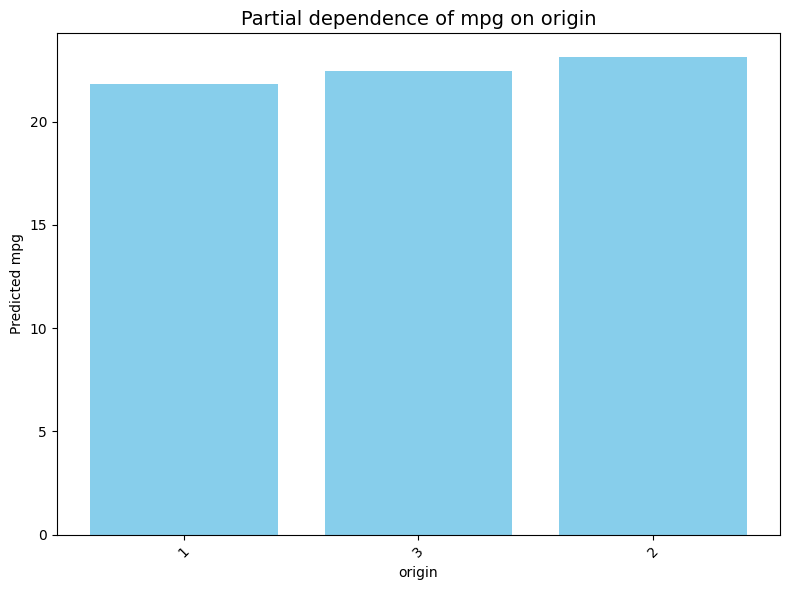

In [120]:
plot_effect("origin")

When examining mpg while **holding weight and year constant**, the differences across vehicle origin still reflect regional design and engineering choices rather than size or age of the car. **American-made vehicles** have slightly lower mpg, indicating that, even for cars of the same weight and year, they are engineered with less fuel-efficient systems or less aerodynamic designs. **Japanese vehicles** show moderately higher mpg, likely due to more efficient engineering and stricter fuel economy standards. **European vehicles** achieve the highest mpg, suggesting a strong emphasis on fuel-efficient technologies and optimization in engine and drivetrain design. These patterns show that, even after controlling for weight and model year, the country of origin captures systematic differences in how vehicles are designed to balance performance and efficiency.

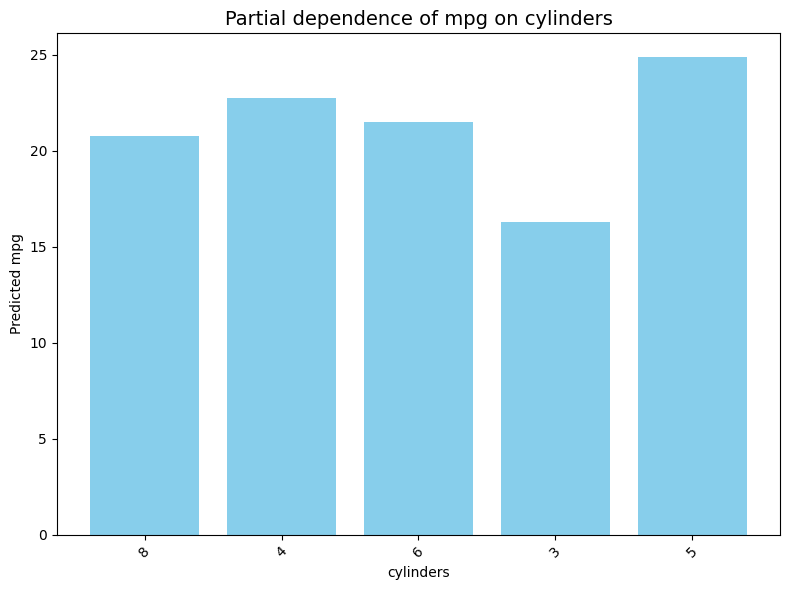

In [125]:
plot_effect("cylinders")

The unusual trend in predicted mpg—where 3-cylinder cars have the lowest mpg, followed by 8, 6, 4, and 5 cylinders—likely arises from a combination of factors related to the dataset and the model. In the Auto dataset, 3- and 5-cylinder cars are rare, so their predicted mpg values are heavily influenced by a few extreme cases. Holding weight and year constant can also create extrapolation effects, since most 3-cylinder cars are lighter than average; the model is predicting mpg for them at a weight that may not exist in the data. Additionally, nonlinear relationships and interactions between cylinders, horsepower, and other variables mean that mpg does not decrease monotonically with cylinder count. These factors together can produce non-intuitive, non-monotonic predicted values, even though the underlying physical expectation is that fewer cylinders generally correspond to higher mpg.